In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import emoji
import pickle
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel

In [83]:
wsb_posts_df = pd.read_csv('LDA/posts_clean_final.csv')

 #with open('post_df.pickle', 'rb') as handle:
 #   wsb_posts_df = pickle.load(handle)

/tmp/ipykernel_61197/2130566979.py:1: DtypeWarning: Columns (16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  wsb_posts_df = pd.read_csv('LDA/posts_clean_final.csv')


In [84]:
wsb_posts_df['document'] = wsb_posts_df.apply(lambda x: str(x.clean_title) + '. ' + str(x.clean_selftext), axis=1)
wsb_posts_df = wsb_posts_df[~wsb_posts_df.document.str.contains('[removed]') & wsb_posts_df.document.notna()]
doc_list = []
for i, r in wsb_posts_df.iterrows():
    doc_list.append(str(r.document).replace('nan', ''))
wsb_posts_df['document'] = doc_list

/tmp/ipykernel_61197/3280831803.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wsb_posts_df['document'] = doc_list


In [85]:
#wsb_posts_df.loc[37, 'document'].replace('nan', '')
wsb_posts_df

,Unnamed: 0,id,author,created_utc,title,selftext,num_comments,clean_title,clean_selftext,num_title_emojis,...,title_length,text_length,score,num_replied_comments,num_replies_by_new,list_new_repliers,num_replies_by_old,list_old_repliers,is_bot,document
23,23,mhjhdu,Man0fG0ld,1.617237e+09,YOU WON'T BELIEVE THIS! GOLDMAN SACHS COMING T...,NaN,1.0,YOU WON'T BELIEVE THIS GOLDMAN SACHS COMING TO...,NaN,0.0,...,12.0,0.0,1.0,1.0,0.0,NaN,1.0,",AutoModerator",False,YOU WON'T BELIEVE THIS GOLDMAN SACHS COMING TO...
26,26,mhjkg9,Prestigious_Quan_328,1.617237e+09,ARE YOU READY FOR TOMORROW 4-1 I KNOW I'M!! DO...,NaN,0.0,ARE YOU READY FOR TOMORROW 4 1 I KNOW I'M DON'...,NaN,2.0,...,12.0,0.0,1.0,0.0,0.0,NaN,0.0,NaN,False,ARE YOU READY FOR TOMORROW 4 1 I KNOW I'M DON'...
37,37,mhjt8k,Federal-Music-2676,1.617238e+09,GME!,NaN,0.0,GME,NaN,0.0,...,1.0,0.0,1.0,0.0,0.0,NaN,0.0,NaN,False,GME.
40,40,mhjyb4,Buzzard241,1.617238e+09,AMC,NaN,0.0,AMC,NaN,0.0,...,1.0,0.0,1.0,0.0,0.0,NaN,0.0,NaN,False,AMC.
41,41,mhjyja,Classic-Ideal,1.617238e+09,LITTLE MVIS GAINS 🚀🚀,NaN,1.0,LITTLE MVIS GAINS,NaN,2.0,...,3.0,0.0,9.0,1.0,0.0,NaN,1.0,",NeverBenCurious",False,LITTLE MVIS GAINS.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085334,1085334,ewoojh,bcheda,1.580478e+09,TSLA,NaN,0.0,TSLA,NaN,0.0,...,1.0,0.0,1.0,0.0,0.0,NaN,0.0,NaN,False,TSLA.
1085424,1085424,ewra8a,pldowd,1.580490e+09,DJ $TSLA 😎,NaN,2.0,DJ TSLA,NaN,1.0,...,2.0,0.0,5.0,2.0,0.0,NaN,0.0,NaN,False,DJ TSLA.
1085452,1085452,ewsaec,wtander1,1.580494e+09,LONG SPCE,NaN,0.0,LONG SPCE,NaN,0.0,...,2.0,0.0,1.0,0.0,0.0,NaN,0.0,NaN,False,LONG SPCE.
1085458,1085458,ewshhr,titty-boys,1.580495e+09,INCOMING STOCK MARKET CRASH! DD ATTACHED,NaN,0.0,INCOMING STOCK MARKET CRASH DD ATTACHED,NaN,0.0,...,6.0,0.0,1.0,0.0,0.0,NaN,0.0,NaN,False,INCOMING STOCK MARKET CRASH DD ATTACHED.


In [86]:
# drop Unnamed column
wsb_posts_df.drop('Unnamed: 0', axis=1, inplace=True)

In [87]:
total_pd_1 = wsb_posts_df[wsb_posts_df.created_utc < 1609459200] # 2020 dataset
total_pd_2 = wsb_posts_df[(1609459200 < wsb_posts_df.created_utc) & (wsb_posts_df.created_utc < 1617235200)] # 2021-01-01 to 2021-03-31
total_pd_3 = wsb_posts_df[1617235200 < wsb_posts_df.created_utc] # 2021-04-01 onwards

## Latent Dirichlet Allocation

In [350]:
word_list = set()
for w in gensim.parsing.preprocessing.STOPWORDS:
    word_list.add(w)
word_list

{'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'bill',
 'both',
 'bottom',
 'but',
 'by',
 'call',
 'can',
 'cannot',
 'cant',
 'co',
 'computer',
 'con',
 'could',
 'couldnt',
 'cry',
 'de',
 'describe',
 'detail',
 'did',
 'didn',
 'do',
 'does',
 'doesn',
 'doing',
 'don',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eg',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'etc',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifte

In [349]:
'fuck' == 'fuck'

True

In [351]:
def lemmatize_stemming(text):
    return SnowballStemmer('english').stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    text = emoji.demojize(text)
    result = []
    for token in gensim.utils.simple_preprocess(text):
        #if token not in word_list and len(token) > 3:
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result



## LDA for 2020

In [378]:
# posts preprocessed
nltk.download('wordnet')
nltk.download('omw-1.4')
posts_processed_1 = total_pd_1.document.map(preprocess)
#posts_processed_2 = total_pd_2.document.map(preprocess)
#posts_processed_3 = total_pd_3.document.map(preprocess)

[nltk_data] Downloading package wordnet to /home/vw/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/vw/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [379]:
# vocabulary
dictionary_1 = gensim.corpora.Dictionary(posts_processed_1)
#dictionary_2 = gensim.corpora.Dictionary(posts_processed_2)
#dictionary_3 = gensim.corpora.Dictionary(posts_processed_3)

In [380]:
# Filter
# less than 15 documents (absolute number) or
# more than 0.5 documents (fraction of total corpus size, not absolute number).
# after the above two steps, keep only the first 100000 most frequent tokens.
dictionary_1.filter_extremes(no_below=5, no_above=0.25, keep_n=40000)
#dictionary_2.filter_extremes(no_below=5, no_above=0.25, keep_n=40000)
#dictionary_3.filter_extremes(no_below=5, no_above=0.25, keep_n=40000)

In [381]:
# bag of words
bow_corpus_1 = [dictionary_1.doc2bow(doc) for doc in posts_processed_1]
#bow_corpus_2 = [dictionary_2.doc2bow(doc) for doc in posts_processed_2]
#bow_corpus_3 = [dictionary_3.doc2bow(doc) for doc in posts_processed_3]

In [382]:
# get coherence scores for different number of topics
coh_lda_models = dict()

for num_topics in tqdm(range(5, 22)):
    lda = gensim.models.LdaMulticore(bow_corpus_1, 
                                     num_topics=num_topics, 
                                     id2word=dictionary_1, 
                                     passes=2, workers=12, random_state = 100)
    
    coh = CoherenceModel(model=lda, texts=posts_processed_1, corpus=bow_corpus_1, coherence='c_v')
    
    coh_lda_models[num_topics] = {'lda': lda, 'coh': coh}
    
    

100%|██████████| 17/17 [00:08<00:00,  2.01it/s]


100%|██████████| 17/17 [00:08<00:00,  2.03it/s]


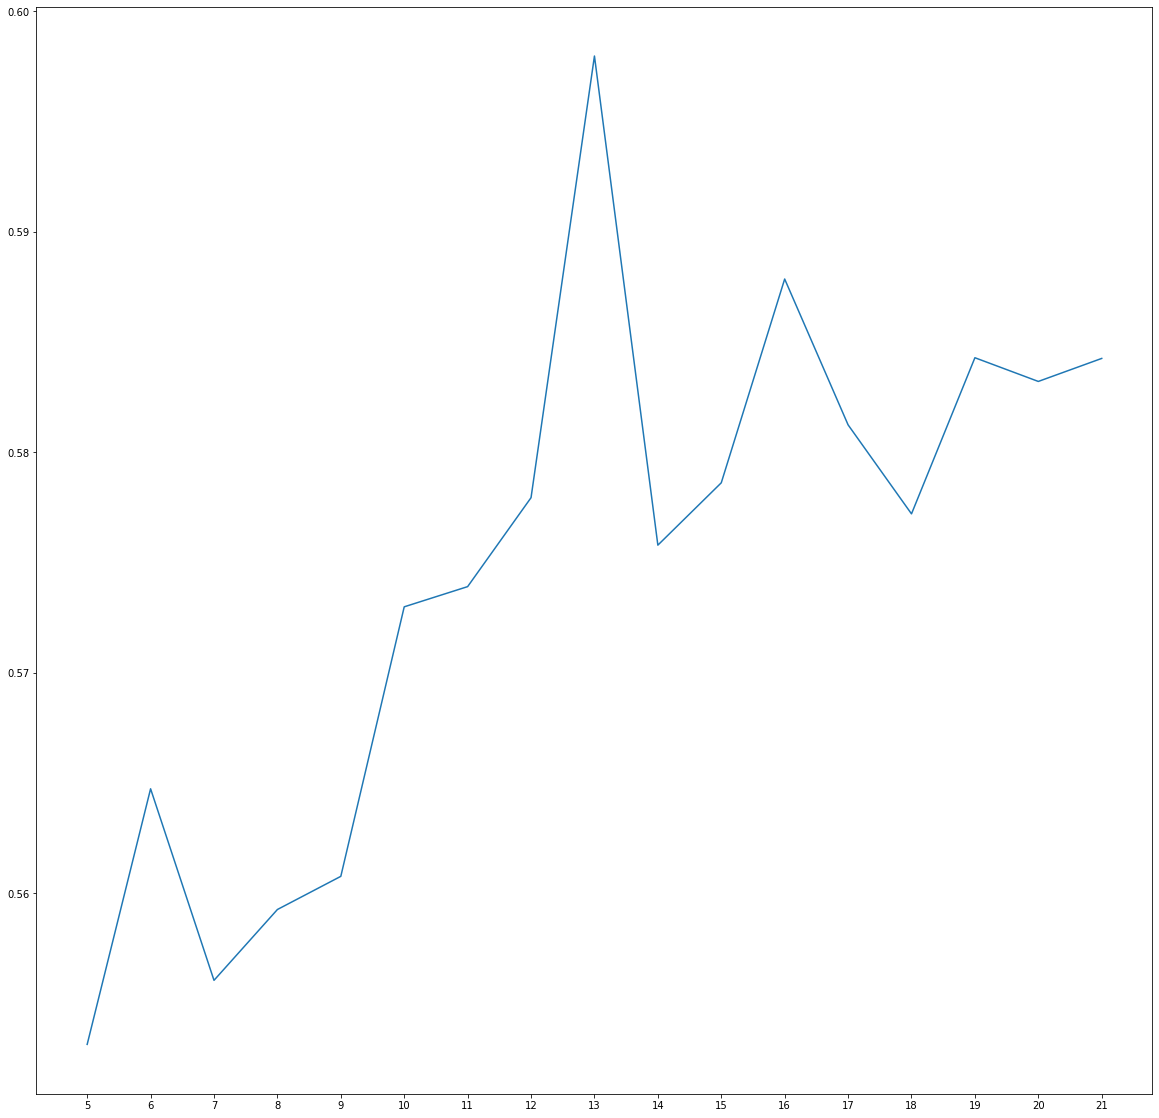

In [383]:
# plot num topics vs. coherence scores
topics = list(coh_lda_models.keys())
scores = [v['coh'].get_coherence() for v in tqdm(coh_lda_models.values())]
plt.figure(figsize=(20, 20))
plt.xticks(np.arange(5,60))
plt.plot(topics, scores)
plt.show()

In [384]:
scores

[0.5531489349611661,
 0.5647367962764983,
 0.5560523561677782,
 0.5592635843457223,
 0.5607674138300548,
 0.5729866556288179,
 0.5739023384602108,
 0.5779350150455425,
 0.5979585285213112,
 0.5757833071342429,
 0.5786091814786762,
 0.5878484034991183,
 0.5812369116648587,
 0.577201327116119,
 0.5842796202120855,
 0.5832050018526818,
 0.5842481801638195]

In [385]:
scores[:16].index(max(scores[:16]))

8

In [390]:
# process all posts to bag-of-words
posts_bow_1 = posts_processed_1.apply(lambda x: dictionary_1.doc2bow(x))
#posts_bow_2 = posts_processed_2.apply(lambda x: dictionary_2.doc2bow(x))
#posts_bow_3 = posts_processed_3.apply(lambda x: dictionary_3.doc2bow(x))

In [391]:
# label the posts using model with 13 topics
best_model = coh_lda_models[13]['lda']
total_pd_1['topic'] = posts_bow_1.apply(lambda x: np.argmax([s for t, s in best_model[x]]))
#total_pd_2['topic'] = posts_bow_2.apply(lambda x: np.argmax([s for t, s in best_model[x]]))
#total_pd_3['topic'] = posts_bow_3.apply(lambda x: np.argmax([s for t, s in best_model[x]]))

/tmp/ipykernel_61197/1052434031.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_pd_1['topic'] = posts_bow_1.apply(lambda x: np.argmax([s for t, s in best_model[x]]))


In [392]:
total_pd_1['topic'].value_counts()
#total_pd_2['topic'].value_counts()
#total_pd_3['topic'].value_counts()

0     1863
3      301
11     287
6      276
10     224
7      215
9      204
1      199
8      191
5      188
4      186
2      181
12     164
Name: topic, dtype: int64

In [393]:
# Topics
for idx, topic in best_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.067*"bear" + 0.063*"pltr" + 0.045*"tendi" + 0.028*"fuck" + 0.026*"musk" + 0.025*"citron" + 0.023*"want" + 0.023*"right" + 0.022*"call" + 0.018*"haha"
Topic: 1 
Words: 0.180*"fuck" + 0.041*"earn" + 0.041*"moon" + 0.036*"bear" + 0.032*"money" + 0.021*"wait" + 0.018*"stop" + 0.017*"nvax" + 0.017*"gild" + 0.016*"take"
Topic: 2 
Words: 0.064*"put" + 0.064*"nkla" + 0.040*"fuck" + 0.038*"spce" + 0.037*"play" + 0.036*"hold" + 0.035*"gain" + 0.030*"babi" + 0.024*"btfd" + 0.020*"invest"
Topic: 3 
Words: 0.186*"pltr" + 0.163*"yolo" + 0.066*"fuck" + 0.048*"sign" + 0.034*"tsla" + 0.028*"bear" + 0.022*"time" + 0.019*"sell" + 0.017*"green" + 0.015*"citron"
Topic: 4 
Words: 0.093*"tsla" + 0.062*"call" + 0.051*"sell" + 0.037*"put" + 0.034*"aapl" + 0.031*"msft" + 0.028*"say" + 0.024*"print" + 0.021*"moon" + 0.020*"amzn"
Topic: 5 
Words: 0.208*"gang" + 0.064*"shit" + 0.042*"rise" + 0.035*"pltr" + 0.029*"bear" + 0.026*"bull" + 0.017*"monday" + 0.017*"diamond" + 0.017*"hand" + 0.015*"hol

In [394]:
# save final data
total_pd_1[['author', 'id', 'num_comments', 'topic', 'document', 'created_utc']]\
.to_csv("wsb_post_period1_LDA_opt_13_final.csv")

In [395]:
from utils import workout_time, create_subframe
total_df_1 = pd.read_csv('wsb_post_period1_LDA_opt_13_final.csv')

total_df_2 = pd.read_csv('wsb_post_period2_LDA_opt_20_final.csv')

total_df_3 = pd.read_csv('wsb_post_period3_LDA_opt_9_final.csv')

In [219]:

total_pd_1['topic'].isnull().values.any()

False

In [396]:
from scipy.stats import mode

def get_trend_labeled_df(period, df):
    if period == 1:
        months = range(1, 13)
    elif period == 2:
        months = range(1, 4)
    else:
        months = range(4, 13)
    #months = range(1, 13) if year == 2020 else range(1, 7)
    annual_df = pd.DataFrame(columns=['author', 'id', 'num_comments', 'topic', 'created_utc', 'is_trending'])
    for month in months:
        df_list = create_subframe(2020, month, df)
        for sub_df in df_list:
            try:
                freq_mode = set(sub_df['topic'].mode())
            except:
                continue
            #freq_mode = mode1(sub_df['topic'].to_numpy())
            dummy_indicator = []
            for i, r in sub_df.iterrows():
                dummy_indicator.append(1) if r.topic in freq_mode else dummy_indicator.append(0)
                #dummy_indicator.append(1) if r.topic != freq_mode else dummy_indicator.append(0)
            sub_df['is_trending'] = dummy_indicator
            annual_df = pd.concat([annual_df, sub_df])
    return annual_df

In [412]:
trend_3_df = get_trend_labeled_df(3, total_df_3[['author', 'id', 'num_comments', 'topic', 'created_utc', 'document']])

In [408]:
trend_1_df

,author,id,num_comments,topic,created_utc,is_trending,document
4337,seaisthememes,eib3oe,0.0,8,1577837267.0,1,happy 2020 autists.
4338,Navdagoat,eif06n,1.0,0,1577859305.0,1,Acb lick.
4339,Dib102001,eiyb2o,0.0,3,1577972171.0,0,It's a sign.
4340,feruiloba,ej3wsn,0.0,0,1577997619.0,0,Bullgang AMD.
4341,Boristhedwarf,ej4j35,0.0,7,1578000162.0,1,Thanks RAD.
...,...,...,...,...,...,...,...
839,TSLAtoINFINITY,knaoak,11.0,6,1609361924.0,0,TSLA 690.
840,Elna_Fybbg,knaw2s,278.0,0,1609362552.0,1,S3XY.
841,manburgger,knb76j,4.0,1,1609363530.0,0,STOP THE COUNT.
842,WarrenFugit,knbxhd,38.0,10,1609365795.0,0,MRNA.


In [72]:
day_2 = create_subframe(2020, 1, total_pd_1)[1]
#day_1['topic'].mode().to_list()
day_2

,id,author,created_utc,title,selftext,num_comments,clean_title,clean_selftext,num_title_emojis,num_text_emojis,...,text_length,score,num_replied_comments,num_replies_by_new,list_new_repliers,num_replies_by_old,list_old_repliers,is_bot,document,topic
1078168,eiyb2o,Dib102001,1.577972e+09,It’s a sign.,NaN,0.0,It's a sign,NaN,0.0,0.0,...,0.0,1.0,0.0,0.0,NaN,0.0,NaN,False,It's a sign. nan,2
1078264,ej3wsn,feruiloba,1.577998e+09,Bullgang AMD,NaN,0.0,Bullgang AMD,NaN,0.0,0.0,...,0.0,4.0,0.0,0.0,NaN,0.0,NaN,False,Bullgang AMD. nan,0
1078288,ej4j35,Boristhedwarf,1.578000e+09,Thanks RAD,NaN,0.0,Thanks RAD,NaN,0.0,0.0,...,0.0,1.0,0.0,0.0,NaN,0.0,NaN,False,Thanks RAD. nan,1
1078304,ej52aj,01212000,1.578002e+09,HASBRO WILL BE A MONEY MACHINE,NaN,0.0,HASBRO WILL BE A MONEY MACHINE,NaN,0.0,0.0,...,0.0,1.0,0.0,0.0,NaN,0.0,NaN,False,HASBRO WILL BE A MONEY MACHINE. nan,3


Produce Bayseian Probability Variable

In [409]:
def initial_state(df, n_topics):
    initial_dict = dict()
    for a in list(df.author):
        initial_dict[str(a)] = [0]*(n_topics+1)
    return initial_dict

def get_bayes_prob(df, initial_dict, n_topics):
    prob_list = []
    for i, r in df.iterrows():
        prob = (initial_dict[r.author][r.topic]+1)/(initial_dict[r.author][-1]+n_topics)
        prob_list.append(prob)
        initial_dict[r.author][r.topic] += 1
        initial_dict[r.author][-1] += 1
    df['topic_prob'] = prob_list
    return df


In [413]:
initial_dict = initial_state(trend_3_df, 9)
trend_prob_df_3 = get_bayes_prob(trend_3_df, initial_dict, 9)


In [414]:
trend_prob_df_3.to_csv("trend_prob_df_3.csv")

Self reply indicator

In [ ]:
#just load the entire dataset and the simple post characterisation pickle, and encode 1 if the author did reply to themselve.
